# Regresión lineal para predicción de progresión de diabetes
- age: Representa la edad del paciente, normalizada (no es la edad real, sino una representación estandarizada).
- sex: Sexo del paciente, representado como una variable numérica normalizada (valores entre -0.5 y 0.5).
- bmi: Índice de Masa Corporal (Body Mass Index, BMI), una medida del peso relativo al cuadrado de la altura.
- bp:
Promedio de presión arterial (Blood Pressure, BP), normalizada.
- s1: Nivel sérico de lípidos totales (colesterol total).
- s2: Nivel sérico de lipoproteínas de baja densidad (LDL, “colesterol malo”).
- s3: Nivel sérico de lipoproteínas de alta densidad (HDL, “colesterol bueno”).
- s4: Relación entre el colesterol total y HDL.
- s5: Nivel sérico de triglicéridos, representado como una medida numérica normalizada.
- s6: Nivel sérico de glucosa en ayuno, una medida clave en el monitoreo de la diabetes.

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

# Cargar el conjunto de datos
diabetes_data = load_diabetes()

# Convertir el conjunto de datos a un DataFrame para facilitar su manipulación
df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)
df['target'] = diabetes_data.target  # Agregar la variable objetivo al DataFrame

# Mostrar las primeras filas del DataFrame
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


Dimensiones: (442, 10) | columnas: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Métricas (LinearRegression):
          Train      Test
MAE     43.484    42.794
MSE   2868.550  2900.194
RMSE    53.559    53.853
R2       0.528     0.453

Baseline (DummyRegressor, Test):
 MAE       64.006
MSE     5361.533
RMSE      73.222
R2        -0.012
Name: Baseline, dtype: float64

CV (5-fold) R² → media ± std: 0.478 ± 0.085

Coeficientes (ordenados por |coef|, datos estandarizados):


,feature,coef_std
0,s1,-44.4489
1,s5,35.1612
2,bmi,25.6071
3,s2,24.6410
4,bp,16.8289
5,s4,13.1388
6,sex,-11.5118
7,s3,7.6770
8,s6,2.3514
9,age,1.7538


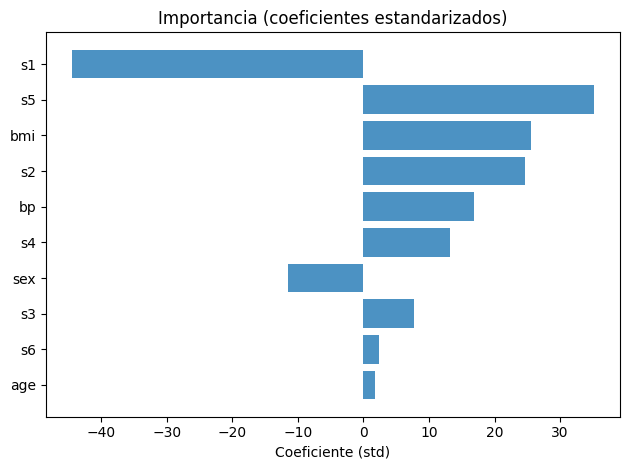

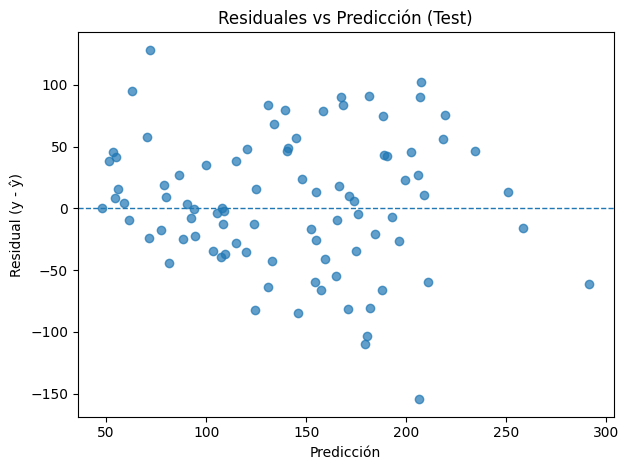


Muestra (y real vs y pred):


,y_real,y_pred
0,219.0,139.55
1,70.0,179.52
2,202.0,134.04
3,230.0,291.42
4,111.0,123.79
5,84.0,92.17
6,242.0,258.23
7,272.0,181.34
8,94.0,90.22
9,96.0,108.63


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

# 1) Cargar datos como DataFrame
diab = load_diabetes(as_frame=True)
df = diab.frame.copy()            # contiene 'target'
X = df.drop(columns=['target'])
y = df['target']

print("Dimensiones:", X.shape, "| columnas:", list(X.columns))

# 2) Train/Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Pipeline: estandarización + regresión lineal
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipe.fit(X_train, y_train)

# 4) Evaluación en train/test
def eval_reg(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return pd.Series({"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}, name=label)

yhat_tr = pipe.predict(X_train)
yhat_te = pipe.predict(X_test)

res_train = eval_reg(y_train, yhat_tr, "Train")
res_test  = eval_reg(y_test,  yhat_te, "Test")
results = pd.concat([res_train, res_test], axis=1)
print("\nMétricas (LinearRegression):\n", results.round(3))

# 5) Comparación con baseline (predice la media)
base = DummyRegressor(strategy="mean")
base.fit(X_train, y_train)
yhat_base = base.predict(X_test)
print("\nBaseline (DummyRegressor, Test):\n",
      eval_reg(y_test, yhat_base, "Baseline").round(3))

# 6) Validación cruzada (R²) sobre todo X,y
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2")
print("\nCV (5-fold) R² → media ± std:",
      f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 7) Coeficientes del modelo (en el espacio estandarizado)
lin = pipe.named_steps["model"]
scaler = pipe.named_steps["scaler"]

coefs = pd.DataFrame({
    "feature": X.columns,
    "coef_std": lin.coef_
}).sort_values("coef_std", key=np.abs, ascending=False)

print("\nCoeficientes (ordenados por |coef|, datos estandarizados):")
display(coefs.reset_index(drop=True).round(4))

# 8) Visualizaciones: coeficientes y residuales
plt.figure()
plt.title("Importancia (coeficientes estandarizados)")
plt.barh(coefs["feature"][::-1], coefs["coef_std"][::-1], alpha=0.8)
plt.xlabel("Coeficiente (std)")
plt.tight_layout()
plt.show()

residuals = y_test - yhat_te
plt.figure()
plt.title("Residuales vs Predicción (Test)")
plt.scatter(yhat_te, residuals, alpha=0.7)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Predicción")
plt.ylabel("Residual (y - ŷ)")
plt.tight_layout()
plt.show()

# 9) Muestra de predicciones vs reales
preview = pd.DataFrame({"y_real": y_test.values, "y_pred": yhat_te}).head(10)
print("\nMuestra (y real vs y pred):")
display(preview.round(2))
